## Association mining

The main goal of market basket analysis is to find association rules, uncovering strong conditional dependencies between groups of items. Eventually, MBA comes up with rules, consisting of antecedents (one itemset), which form condition, and consequents (another itemset), which are dependent on antecedents.

There are many ways to measure magnitudes of relation among itemsets. The main metrics in MBA are:
- support = probability of itemset
- confidence = conditional probability of consequents, given antecedents present
- lift = confidence divided by support of consequents, or, put simply, raise in probability, given antecedents present

MBA is performed by __utils.mine_associations__ with two separate steps. First step finds all frequent enough itemsets, using FP-Growth algorithm (smart Apriori alternative). Second step, mixes different itemsets to find confident enough rules. As a result there is tabular data, prodiving consequents and antecedents, and all usefull metrics values.

As there is huge sparse portion of encoded data, several tricks were used to speed computations up: 
- __utils.yield_materials_support__ calculates support value per each material, by estimating sparse columns density. Thus, encoded materials could be filtered by support threshold  before using full scale MBA.
- __utils.locate_orders_encoded__ does what simple dataframe selection by index does, but much faster. Given sparsity of majority of encoded orders columns, it converts this sparse matrix to appropriate format, efficient for rows selection. And then __utils.locate_orders_encoded__ gathers everything together.

All threshold values were selected for demonstrative purposes.

In [1]:
import numpy
import pandas

%matplotlib inline
from matplotlib import pyplot as plot

from utils import yield_materials_support, locate_orders_encoded, mine_associations

In [2]:
orders = pandas.read_pickle('data/orders_p.pkl.gz')

In [3]:
materials = dict(yield_materials_support(orders))
supports = list(materials.values())

print('Materials supports (min, max):', (min(supports), max(supports)))
print('Materials supports median:', numpy.median(supports))
print('Materials supports 95 percentile:', numpy.percentile(supports, 95))
print('Materials supports above .1 percent threshold:', sum(numpy.array(supports) >= .001))

Materials supports (min, max): (4.3645765727860793e-07, 0.06214589644692915)
Materials supports median: 4.3645765727860794e-06
Materials supports 95 percentile: 0.0005448737393466132
Materials supports above .1 percent threshold: 535


In [4]:
orgs = dict((
    (
        org,
        len(list(yield_materials_support(locate_orders_encoded(orders, indexes), .001)))
    )
    for (org, indexes) in orders.groupby('org').groups.items()
))

print('Organizations distribution of materials supported above .1 percent threshold:')
for (org, support) in orgs.items():
    print('{:<10} {}'.format(org, support))

Organizations distribution of materials supported above .1 percent threshold:
1000       519
2000       580
3000       562
4001       561
7000       772


In [5]:
mining_params = {
    'support_threshold': .001,
    'confidence_threshold': .9,
    'lift_threshold': 1
}

In [6]:
associations = mine_associations(orders, **mining_params)
associations['org'] = pandas.Series([ None ] * len(associations))

In [7]:
for (org, indexes) in orders.groupby('org').groups.items():
    org_associations = mine_associations(locate_orders_encoded(orders, indexes), **mining_params)
    org_associations['org'] = [ org ] * len(org_associations)

    associations = associations.append(org_associations)

In [8]:
distribution = associations.org.transform(lambda v: str(v)).value_counts()

print('{} associations for organization "7000" vs {} as max of rest organizations associations'
    .format(
        distribution['7000'], 
        max(( distribution[key] for key in set(distribution.keys()).difference({ '7000' }) ))
    )
)

2561 associations for organization "7000" vs 29 as max of rest organizations associations


There is huge amount of additional rules uncovered by MBA for ogranization "7000". For demonstrative purposes, rules are filtered even further using .02 support threshold.

In [9]:
associations = associations[(associations.org != 7000) | (associations.support >= .02)]

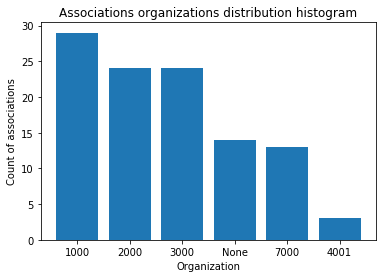

In [10]:
distribution = associations.org.transform(lambda v: str(v)).value_counts()

plot.bar(distribution.keys(), distribution.values)
plot.title('Associations organizations distribution histogram')
plot.xlabel('Organization')
plot.ylabel('Count of associations'.format(len(orders)))
plot.show()

In [11]:
associations = associations[[ 'org', *[ column for column in list(associations.columns) if (column != 'org') ] ]]

joiner = lambda b: ' '.join(b)
associations.antecedents = associations.antecedents.transform(joiner)
associations.consequents = associations.consequents.transform(joiner)

In [12]:
associations.to_csv('data/associations.csv', index=False)

Plenty enough rules uncovered and written to csv. Deal with it